## A Business Decision

Since I'm fighting for people (including myself) to recognize that some of what I did in the past years also has *practical* (i.e., marketable 😬) relevance, let's imagine this business example that I am told is very important and ubiquitous:

You're running an avocado business with a website where people can sign up for your avocado delivery service. Now some smartass behavioral scientist sees your page and yells: "You could do so much better if you just knew something about how people allocate their attention and how it influences their decision-making!"

Now, you're also smart, so you pay this handsome fellow a handsome amount of money to give you some *actionable insights*✨ and improve your landing page. While your cognitive dissonance tries its hardest to convince you of how well the money was spent, you also paid a lot for your MBA, so you plan to run a proper experiment of the new design's effectiveness. 

### The Problem in Brief

Traditional frequentist testing must run the whole sample that was planned for and painfully mustn't peak at the results while data are coming in. That makes them inflexible and can bring you in weird situations: What if someone asks for intermediate results? Hm. You can report them, but act on them? Nope, that would [increase your chances of a false positive](reference).^[There are frequentist approaches for sequential testing, we'll get back to that.]

I'll demonstrate, how Bayesian sequential testing can be helpful to address these issues and can provide a more intuitive and actionable✨ interpretation of your data: Specifically it allows you to

- Check results **anytime** without penalty
- act on intermediate results, which could mean stoping your experiment earlier, saving time, money and opportunity.

Also, while I give this a business spin, the same concept applies in *research* questions: Whenever an intervention is tested against a control, the goal is to robustly assess if the intervention works. But it would also be nice (and in many cases the ethical thing to do) to save time, money, and call the decision as soon as you feel confident enough. Of course, you don't want to be *premature*. It's more like eating the avocado when it's just right, not still hard (too soon) or rotten (too late).

## What you were taught in statistics 101

The basic frequentist approach to this would include:

1. Run a power analysis to compute the required sample size
2. Collect all data - no peeking!
3. Run the test and make a decision

### Power analysis

First, let's determine the required sample size using traditional methods. The first variable we need to decide on is the effect size we want to be able to detect. Let's assume, our current data shows that your website has a sign-up rate of 5%. You expect the new design to improve this by 20% ("relative lift") to 6%, so we're looking to detect a 1% effect.  
Next, we need to determine the test's power, that is, the probability to find the effect, if the effect was real. In this case, we'd really hate to miss out on this opportunity of an improved website, so we'll set a high power of 90%.  
Finally, we need to define a false-positive rate that we're okay with. We'll stick to the regular α = 0.05, meaning that in 5% of studies like this, we'll conclude that there is an effect, even though there was just noise.

In [2]:
# | code-fold: false
# | code-summary: Import packages

# TODO remove before sharing
%load_ext autoreload 
%autoreload 2

# todo: strip to what's used
import matplotlib.pyplot as plt
import myplotlib as my
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats.proportion import proportion_confint

# Import our package
import src.bayesian_ab as bab

In [ ]:
# True rates
true_p_control = 0.05  # we have this from our pre-experiment data
relative_lift = 0.2  # minimum detectable effect in relative terms

# Run power analysis
# this function wraps statsmodels.stats.power.zt_ind_solve_power
power_result = bab.frequentist.power_analysis(
    p_control=true_p_control,
    relative_lift=relative_lift,
    power=0.9,
    alpha=0.05,
    alternative="larger",
)
print(power_result)

PowerAnalysisResult(n_per_group=8885, 
total_n=17770, effect_size=0.0439, 
power=0.90, alpha=0.05, 
p_control=0.0500, p_treatment=0.0600, 
relative_lift=0.2000)


Now we have a total sample size and we can compute how long this experiment would take to run, with our expected daily visitor number:

In [ ]:
daily_n_per_group = 500  # half our daily visitors
n_days = int(np.ceil(power_result.n_per_group / daily_n_per_group))
n_days
print(f"The experiment needs to run for {n_days} days.")

The experiment needs to run for 18 days.


### Run the experiment

Next, we'd run our experiment. Here, we'll simulate data instead, but make it look like it came in day by day, as it would in reality:

In [ ]:
# Simulate daily data
true_p_treatment = true_p_control * (1 + relative_lift)
data = bab.simulation.simulate_ab_test(
    n_days=n_days,
    daily_n=daily_n_per_group,
    p_a=true_p_control,
    p_b=true_p_treatment,
    seed=10439,
)

In [ ]:
# | code-fold: true
# | code-summary: Add some additional metrics to the data for visualization

# Add descriptive labels
data["design"] = data["variant"].map({"A": "Control", "B": "New Design"})
data["signups"] = data["conversions"]
data["visitors"] = data["n"]

# Add cumulative metrics
data["n_cum"] = data.groupby("variant")["n"].cumsum()
data["conversions_cum"] = data.groupby("variant")["conversions"].cumsum()

# Add confidence intervals for cumulative counts
ci = proportion_confint(
    count=data["conversions_cum"], nobs=data["n_cum"], method="wilson", alpha=0.05
)
data["ci_lower"] = ci[0]
data["ci_upper"] = ci[1]

# Little overview
data[["day", "design", "visitors", "signups"]].set_index(["day", "design"]).head(5)

visitors  signups
day design                       
1   Control          500       30
    New Design       500       25
2   Control          500       23
    New Design       500       24
3   Control          500       24

### Visualize Data Arrival

Let's see what our data look like:

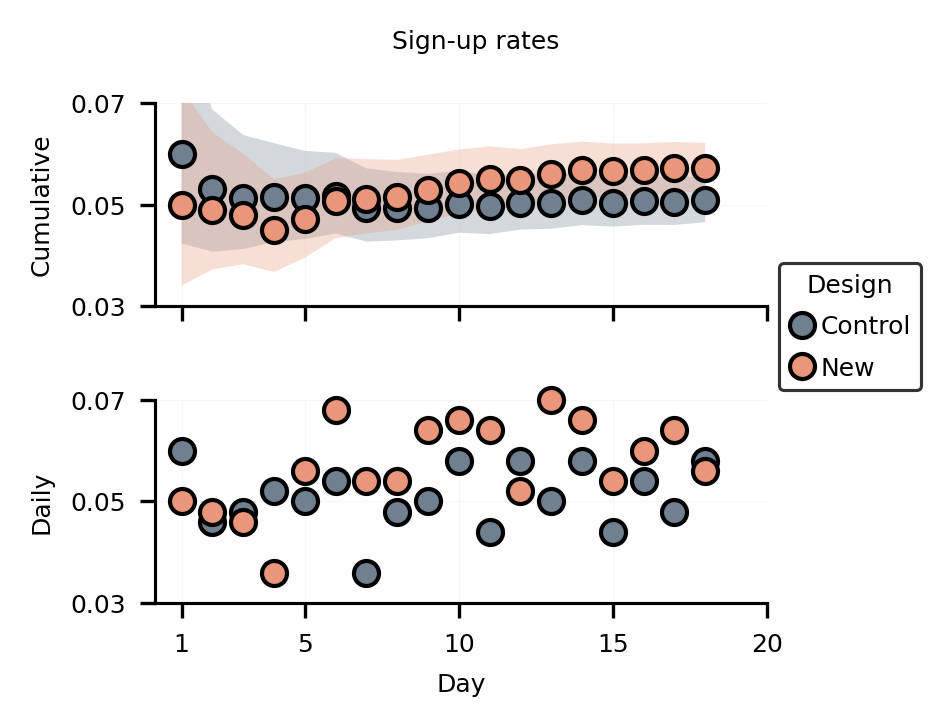

In [ ]:
# | label: fig-data
# | fig-cap: "Experiment data. The top panel shows sign-up rate data over the cumulative data. The bottom panel shows the sign-up rates for each day."
# | code-fold: true
# | code-summary: Show plotting function

fig, axs = plt.subplots(
    2, 1, sharex=True, sharey=True, figsize=my.utilities.cm2inch(8, 6)
)

labels = {"A": "Control", "B": "New"}

for v in ["A", "B"]:
    data_v = data.query("variant == @v")

    # Top: Daily cumulative proportion
    axs[0].plot(
        data_v["day"],
        data_v["conversions_cum"] / data_v["n_cum"],
        "o",
        clip_on=False,
        label=labels[v],
    )
    axs[0].fill_between(
        data_v["day"], data_v["ci_lower"], data_v["ci_upper"], alpha=0.3, zorder=-1
    )

    # Bottom: Daily proportion
    axs[1].plot(data_v["day"], data_v["conversions"] / data_v["n"], "o", clip_on=False)

# Labels
fig.suptitle("Sign-up rates")
axs[0].set_ylabel("Cumulative")
axs[1].set_ylabel("Daily")
axs[1].set_xlabel("Day")
# Ticks and Limits
axs[0].set_ylim(0.03, 0.07)
axs[0].set_yticks([0.03, 0.05, 0.07])
axs[1].set_xticks([1, 5, 10, 15, 20])
for ax in axs:
    ax.grid(alpha=0.1, lw=0.25, fillstyle="top")
# axs[1].set_ylim(0, .1)
# Legend
axs[0].legend(bbox_to_anchor=(1, -0.1), loc="center left", title="Design")
# Layout
fig.tight_layout(h_pad=-0.3)
fig.align_ylabels()

Imagine seeing this data as it came in. On day one, you're really optimistic and can't wait to see how well the new landing page will perform. Think of all the avocados you will sell! At the end of the day, however, you mainly feel regret: The new design performed *worse* than your old trusted one. The new one doesn't even do any better than your historical average of 5%. You think about calling off the whole thing and asking for a refund, but then notice the huge error bars on those numbers (@fig-data; top panel) and decide to do the "right thing" and let the experiment run its course.  

In the next few days, however, your hopes for a bright avocado selling future are crushed even more. While the old design doesn't perform as well as on day one anymore, the new design keeps on tanking more. You call your data scientist who runs the study, but they've called in sick (because they too saw the data coming in...). You have no chance but to let the experiment roll.  

And what a twist. starting from day five, the new design (almost) consistently outperforms the old one and the long term sign-up rates (@fig-data; top panel) indicate a solid 1% increase.

### Run the test

After data are collected, the next step is to run our test. Specifically, we're running a [$z$-test]([$z$-test](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html)) on two the proportions:

In [ ]:
# Run traditional frequentist test (wraps statsmodels.stats.proportion.proportions_ztest)
freq_result = bab.frequentist.proportion_test(data, alpha=0.05, alternative="larger")
freq_result

ProportionTestResult(z_statistic=1.8468, 
p_value=0.0324, significant=True, 
alpha=0.05, rate_a=0.0509, 
rate_b=0.0571, absolute_lift=0.0062, 
relative_lift=0.1223, ci_a=(0.04634846030152203, 0.05542931747625574), 
ci_b=(0.052316897284641964, 0.06190532493758026), n_a=9000, n_b=9000, 
alternative='larger')

Hallelujah, what a ride! The $p$-value is below the magical limit of 0.05. The effect is significant💞. Life is good. Science works.

## 4. Bayesian Sequential Analysis

Now let's apply Bayesian methods that allow checking results at any time:

In [ ]:
# Run Bayesian sequential analysis using probability threshold
results_df = bayesian_sequential_analysis(
    data, criterion="probability", threshold=0.95, seed=42
)

results_df[
    ["day", "n_per_variant", "metric_value", "should_stop", "decision"]
].set_index(["day"]).head()

,n_per_variant,metric_value,should_stop,decision
day,,,,
1,250,0.3456,False,continue
2,500,0.7080,False,continue
3,750,0.6829,False,continue
4,1000,0.8988,False,continue
5,1250,0.9223,False,continue


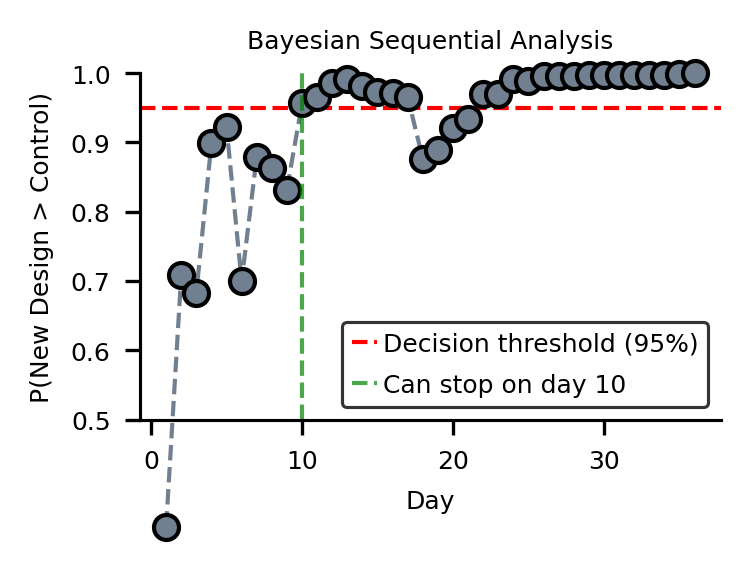


✓ Can stop on day 10 with 95% confidence
  vs. 36 days for traditional testing
  Savings: 72% reduction in experiment duration


In [ ]:
# | code-fold: true
# | code-summary: Show code

# Visualize sequential analysis (note: using prob_b_better from info dict for compatibility)
results_df["prob_b_better"] = results_df["info"].apply(
    lambda x: x.get("prob_b_better", x.get("metric_value", 0))
)
plot_sequential_probability(results_df, threshold=0.95)
plt.show()

# Report stopping time
stop_day = results_df[results_df["should_stop"]]["day"].min()
if pd.notna(stop_day):
    savings = 100 * (1 - stop_day / n_days)
    print(f"\n✓ Can stop on day {int(stop_day)} with 95% confidence")
    print(f"  vs. {n_days} days for traditional testing")
    print(f"  Savings: {savings:.0f}% reduction in experiment duration")
else:
    print("\nNeed more days to reach 95% confidence")

### Posterior Distributions

Visualize the final posterior beliefs about each variant's true conversion rate:

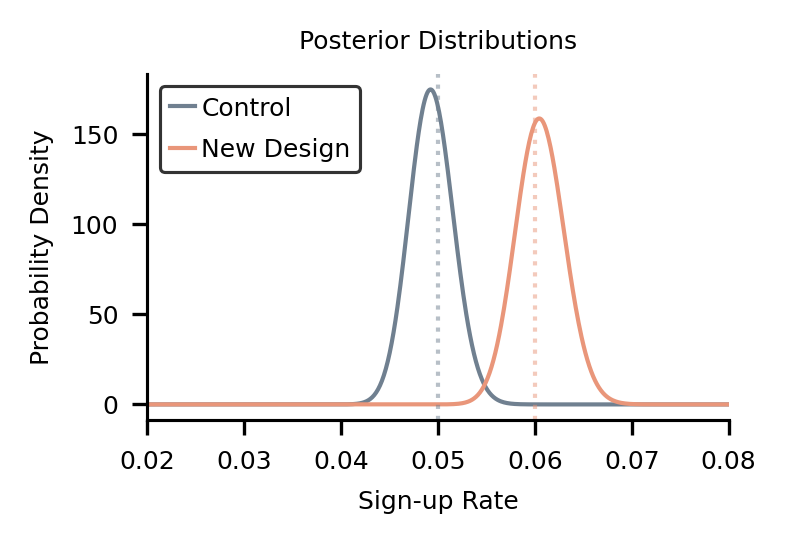

Posterior means:
  Control:     4.9%
  New Design:  6.1%

95% Credible Intervals:
  Control:     [4.5%, 5.4%]
  New Design:  [5.6%, 6.6%]


In [ ]:
# | code-fold: true
# | code-summary: Show code

# Calculate final totals for posterior visualization
final_data = data.groupby("variant")[["n", "conversions"]].sum()

# Get final posterior parameters
signups_a = final_data.loc["A", "conversions"]
visitors_a = final_data.loc["A", "n"]
alpha_a, beta_a = get_posterior_parameters(signups_a, visitors_a)

signups_b = final_data.loc["B", "conversions"]
visitors_b = final_data.loc["B", "n"]
alpha_b, beta_b = get_posterior_parameters(signups_b, visitors_b)

# Plot
ax = plot_posteriors(alpha_a, beta_a, alpha_b, beta_b, true_rates)
ax.set_xlim(0.02, 0.08)
plt.show()

# Summary statistics
print(f"Posterior means:")
print(f"  Control:     {alpha_a/(alpha_a + beta_a):.1%}")
print(f"  New Design:  {alpha_b/(alpha_b + beta_b):.1%}")
print(f"\n95% Credible Intervals:")
print(
    f"  Control:     [{stats.beta.ppf(0.025, alpha_a, beta_a):.1%}, {stats.beta.ppf(0.975, alpha_a, beta_a):.1%}]"
)
print(
    f"  New Design:  [{stats.beta.ppf(0.025, alpha_b, beta_b):.1%}, {stats.beta.ppf(0.975, alpha_b, beta_b):.1%}]"
)

## 5. Expected Loss

Different criterion that's also very nice to track with Bayes.

## Acknowledgments & Further Reading

**Educational Purpose:** This notebook is a learning exercise for understanding Bayesian sequential A/B testing. While the concepts are well-established in industry and academia, implementing them from scratch has been valuable for deepening my statistical intuition. I hope it's useful for others learning these methods too.

**This is Not Novel:** Bayesian sequential testing for A/B tests is well-established:
- VWO implemented this approach in production in 2015 ([technical whitepaper](https://cdn2.hubspot.net/hubfs/310840/VWO_SmartStats_technical_whitepaper.pdf))
- Academic foundations date back decades (see Berger & Berry, 1988)
- Many SaaS platforms (VWO, Dynamic Yield, AB Tasty) use these methods

**Essential Reading:**

*Bayesian A/B Testing:*
- [Evan Miller's "Simple Sequential A/B Testing"](https://www.evanmiller.org/sequential-ab-testing.html) - Accessible introduction
- [Chris Stucchio's "Bayesian A/B Testing at VWO"](https://cdn2.hubspot.net/hubfs/310840/VWO_SmartStats_technical_whitepaper.pdf) - Implementation details
- [David Robinson's "Is Bayesian A/B Testing Immune to Peeking?"](http://varianceexplained.org/r/bayesian-ab-testing/) - Important critique showing Bayesian methods are NOT peeking-proof

*Industry Practice:*
- [Microsoft's ExP Platform](https://www.exp-platform.com/) - How large tech companies actually run experiments (frequentist methods)
- [Spotify's Sequential Testing Framework Comparison](https://engineering.atspotify.com/2023/03/choosing-sequential-testing-framework-comparisons-and-discussions) - Detailed analysis of GST vs. mSPRT vs. GAVI

*Key Papers:*
- Johari et al. (2021) "[Always Valid Inference](https://arxiv.org/abs/1512.04922)" - Frequentist sequential testing foundations
- Deng et al. (2013) "[Improving the Sensitivity of Online Controlled Experiments](https://exp-platform.com/Documents/2013-02-CUPED-ImprovingSensitivityOfControlledExperiments.pdf)" - CUPED variance reduction

**Alternative Approaches Not Covered Here:**

This notebook focuses on simple Bayesian sequential testing, but industry has developed other important methods:

- **CUPED (Controlled-experiment Using Pre-Experiment Data)** - Variance reduction using pre-experiment covariates; can reduce experiment time by 50-65%. Used by Microsoft, Netflix, Meta. [Paper](https://exp-platform.com/Documents/2013-02-CUPED-ImprovingSensitivityOfControlledExperiments.pdf)

- **Group Sequential Tests (GST)** - Frequentist sequential testing with alpha spending functions; maintains valid Type I error control. Used by Spotify, LinkedIn. [Jennison & Turnbull, 1999](https://www.jstor.org/stable/2673986)

- **Anytime-Valid Inference** - Methods providing valid p-values regardless of when you stop. Used by Netflix. [Ramdas et al., 2020](https://arxiv.org/abs/1810.08240)

- **Multi-Armed Bandits** - Adaptive allocation that sends more traffic to better variants; trades statistical confidence for reduced regret. [See Optimizely's implementation](https://www.optimizely.com/optimization-glossary/multi-armed-bandit/)

**Why These Matter:** Major tech companies (Google, Microsoft, Amazon, Netflix) primarily use frequentist methods with variance reduction and sequential testing. Bayesian methods have found their niche in mid-market SaaS platforms where interpretability is valued. Understanding both approaches and when each adds value is more important than dogmatic framework preference.

**What's Actually Novel in This Notebook:** The comparison framework, expected loss stopping criteria, and hopefully a clear pedagogical explanation of the tradeoffs.

## Future Directions

**This notebook covers the simplest case:** two variants, binary outcome, independent observations. Both frequentist and Bayesian approaches handle this well.

**Bayesian methods become increasingly valuable for:**
- **Hierarchical models** - Testing across segments (mobile/desktop/tablet) with partial pooling
- **Covariate adjustment** - Modeling time-of-day effects, user characteristics, or complex regression structures
- **Non-standard metrics** - Revenue (continuous), time-to-conversion (survival), or heavy-tailed distributions
- **Incorporating historical data** - Using past experiments to inform priors for new tests

Future articles may explore these extensions with PyMC. The conjugate prior foundation established here generalizes naturally to these more complex scenarios where MCMC sampling becomes necessary.